<a href="https://colab.research.google.com/github/Daksha-AI/Group_1_NLP_Financial_Investment_Project/blob/main/FinSight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Locate and load the CSV**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pratyushpuri/financial-news-market-events-dataset-2025")

print("Path to dataset files:", path)

100%|██████████| 408k/408k [00:00<00:00, 77.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/pratyushpuri/financial-news-market-events-dataset-2025/versions/1


In [2]:
import os, glob
csvs = glob.glob(path + "/**/*.csv", recursive=True)
csvs

['/root/.cache/kagglehub/datasets/pratyushpuri/financial-news-market-events-dataset-2025/versions/1/financial_news_events.csv']

In [6]:
news_csv = csvs[0]
import pandas as pd
news = pd.read_csv(news_csv, low_memory=False)
print(news.shape)
news.head()


(3024, 12)


,Date,Headline,Source,Market_Event,Market_Index,Index_Change_Percent,Trading_Volume,Sentiment,Sector,Impact_Level,Related_Company,News_Url
0,2025-05-21,Nikkei 225 index benefits from a weaker yen,Times of India,Commodity Price Shock,DAX,3.52,166.45,NaN,Technology,High,Goldman Sachs,https://timesofindia.indiatimes.com/business/m...
1,2025-05-18,Government subsidy program gives a lift to the...,Financial Times,Central Bank Meeting,Shanghai Composite,-3.39,57.61,NaN,Retail,Low,ExxonMobil,https://timesofindia.indiatimes.com/business/m...
2,2025-06-25,New housing data release shows a slowdown in m...,The Hindu Business Line,Consumer Confidence Report,Shanghai Composite,-0.05,403.22,Neutral,Retail,Medium,Boeing,https://www.moneycontrol.com/us-markets/sp-500
3,2025-07-21,Massive stock buyback program announced by a c...,The Economist,Commodity Price Shock,NSE Nifty,-2.29,100.11,Positive,Consumer Goods,Low,Samsung Electronics,https://www.cnbc.com/2025/09/automotive-indust...
4,2025-07-23,Government spending bill is expected to stimul...,The Motley Fool,Inflation Data Release,Nasdaq Composite,-3.97,438.22,Negative,Consumer Goods,Low,JP Morgan Chase,https://www.bloomberg.com/australia/asx-200-pe...


**Identify key columns**

In [7]:
news.columns.tolist()

['Date',
 'Headline',
 'Source',
 'Market_Event',
 'Market_Index',
 'Index_Change_Percent',
 'Trading_Volume',
 'Sentiment',
 'Sector',
 'Impact_Level',
 'Related_Company',
 'News_Url']

In [12]:
news.head(2)



,Date,Headline,Source,Market_Event,Market_Index,Index_Change_Percent,Trading_Volume,Sentiment,Sector,Impact_Level,Related_Company,News_Url
0,2025-05-21,Nikkei 225 index benefits from a weaker yen,Times of India,Commodity Price Shock,DAX,3.52,166.45,NaN,Technology,High,Goldman Sachs,https://timesofindia.indiatimes.com/business/m...
1,2025-05-18,Government subsidy program gives a lift to the...,Financial Times,Central Bank Meeting,Shanghai Composite,-3.39,57.61,NaN,Retail,Low,ExxonMobil,https://timesofindia.indiatimes.com/business/m...


In [13]:
news['date'] = pd.to_datetime(news['Date'], errors='coerce')
news['title'] = news['Headline'].astype(str)
news['content'] = news['Headline'].astype(str)
news['event_type'] = news['Market_Event'].astype(str)
news['symbol'] = news['Related_Company'].astype(str)

news = news[['date', 'title', 'content', 'event_type', 'Sentiment', 'symbol', 'Sector', 'Impact_Level']]

news.head()


,date,title,content,event_type,Sentiment,symbol,Sector,Impact_Level
0,2025-05-21,Nikkei 225 index benefits from a weaker yen,Nikkei 225 index benefits from a weaker yen,Commodity Price Shock,NaN,Goldman Sachs,Technology,High
1,2025-05-18,Government subsidy program gives a lift to the...,Government subsidy program gives a lift to the...,Central Bank Meeting,NaN,ExxonMobil,Retail,Low
2,2025-06-25,New housing data release shows a slowdown in m...,New housing data release shows a slowdown in m...,Consumer Confidence Report,Neutral,Boeing,Retail,Medium
3,2025-07-21,Massive stock buyback program announced by a c...,Massive stock buyback program announced by a c...,Commodity Price Shock,Positive,Samsung Electronics,Consumer Goods,Low
4,2025-07-23,Government spending bill is expected to stimul...,Government spending bill is expected to stimul...,Inflation Data Release,Negative,JP Morgan Chase,Consumer Goods,Low


**Build the NewsAgent class**

In [14]:
import pandas as pd
from textblob import TextBlob

class NewsAgent:
    def __init__(self, news_df: pd.DataFrame):
        """
        Initializes the NewsAgent with a dataframe of financial news.
        Expected columns: ['date', 'title', 'content', 'event_type', 'Sentiment', 'symbol']
        """
        self.news = news_df.copy()
        self.clean_data()

    def clean_data(self):
        """Clean and standardize text content."""
        self.news['content'] = (
            self.news['content']
            .astype(str)
            .str.replace('\n', ' ')
            .str.replace('\r', ' ')
            .str.strip()
        )
        self.news.dropna(subset=['content'], inplace=True)

    def filter_by_symbol(self, symbol: str):
        """Filter articles that mention a specific company or stock symbol."""
        mask = self.news['symbol'].str.contains(symbol, case=False, na=False)
        filtered = self.news[mask].copy()
        return filtered

    def compute_sentiment(self, text):
        """Compute sentiment polarity using TextBlob."""
        return TextBlob(text).sentiment.polarity

    def add_sentiment(self):
        """Add computed sentiment score to the dataframe."""
        self.news['computed_sentiment'] = self.news['content'].apply(self.compute_sentiment)
        return self.news

    def summarize_article(self, text, max_words=30):
        """Simple extractive summarization using first N words."""
        words = text.split()
        return " ".join(words[:max_words]) + "..." if len(words) > max_words else text

    def summarize_all(self):
        """Add a short summary for each article."""
        self.news['summary'] = self.news['content'].apply(self.summarize_article)
        return self.news


In [15]:
na = NewsAgent(news)
aapl_news = na.filter_by_symbol("AAPL")
aapl_news = na.add_sentiment()
aapl_news = na.summarize_all()
aapl_news.head()

,date,title,content,event_type,Sentiment,symbol,Sector,Impact_Level,computed_sentiment,summary
0,2025-05-21,Nikkei 225 index benefits from a weaker yen,Nikkei 225 index benefits from a weaker yen,Commodity Price Shock,NaN,Goldman Sachs,Technology,High,0.000000,Nikkei 225 index benefits from a weaker yen
1,2025-05-18,Government subsidy program gives a lift to the...,Government subsidy program gives a lift to the...,Central Bank Meeting,NaN,ExxonMobil,Retail,Low,0.000000,Government subsidy program gives a lift to the...
2,2025-06-25,New housing data release shows a slowdown in m...,New housing data release shows a slowdown in m...,Consumer Confidence Report,Neutral,Boeing,Retail,Medium,0.136364,New housing data release shows a slowdown in m...
3,2025-07-21,Massive stock buyback program announced by a c...,Massive stock buyback program announced by a c...,Commodity Price Shock,Positive,Samsung Electronics,Consumer Goods,Low,0.000000,Massive stock buyback program announced by a c...
4,2025-07-23,Government spending bill is expected to stimul...,Government spending bill is expected to stimul...,Inflation Data Release,Negative,JP Morgan Chase,Consumer Goods,Low,-0.100000,Government spending bill is expected to stimul...


In [16]:
import re

def extract_key_points(text):
    """
    Extract simple key phrases from the headline/content.
    (In a real LLM chain, this would use a model like GPT-4.)
    """
    text = text.lower()
    keywords = re.findall(r'\b[a-z]{4,}\b', text)
    top_words = list(pd.Series(keywords).value_counts().head(5).index)
    return ", ".join(top_words)

def chain_prompt(row):
    """Simulate a reasoning chain: clean → analyze → summarize."""
    key_points = extract_key_points(row['content'])
    sentiment = "positive" if row['computed_sentiment'] > 0 else (
                 "negative" if row['computed_sentiment'] < 0 else "neutral")
    summary = f"Headline: {row['title']} | Key points: {key_points} | Sentiment: {sentiment}"
    return summary

aapl_news['prompt_chain_summary'] = aapl_news.apply(chain_prompt, axis=1)
aapl_news[['date','title','prompt_chain_summary']].head(3)


,date,title,prompt_chain_summary
0,2025-05-21,Nikkei 225 index benefits from a weaker yen,Headline: Nikkei 225 index benefits from a wea...
1,2025-05-18,Government subsidy program gives a lift to the...,Headline: Government subsidy program gives a l...
2,2025-06-25,New housing data release shows a slowdown in m...,Headline: New housing data release shows a slo...


In [17]:
def route_article(row):
    """
    Simple routing logic — decide which research agent should handle the news.
    """
    text = row['content'].lower()
    if any(k in text for k in ['earnings', 'revenue', 'profit', 'q1', 'q2', 'q3', 'q4']):
        return 'Earnings'
    elif any(k in text for k in ['merger', 'acquisition', 'buyout']):
        return 'M&A'
    elif any(k in text for k in ['inflation', 'interest rate', 'federal reserve', 'bank']):
        return 'Macro'
    elif any(k in text for k in ['tech', 'ai', 'product', 'launch']):
        return 'Innovation'
    else:
        return 'General'

aapl_news['route'] = aapl_news.apply(route_article, axis=1)
aapl_news[['date','title','route']].head(3)


,date,title,route
0,2025-05-21,Nikkei 225 index benefits from a weaker yen,General
1,2025-05-18,Government subsidy program gives a lift to the...,General
2,2025-06-25,New housing data release shows a slowdown in m...,General


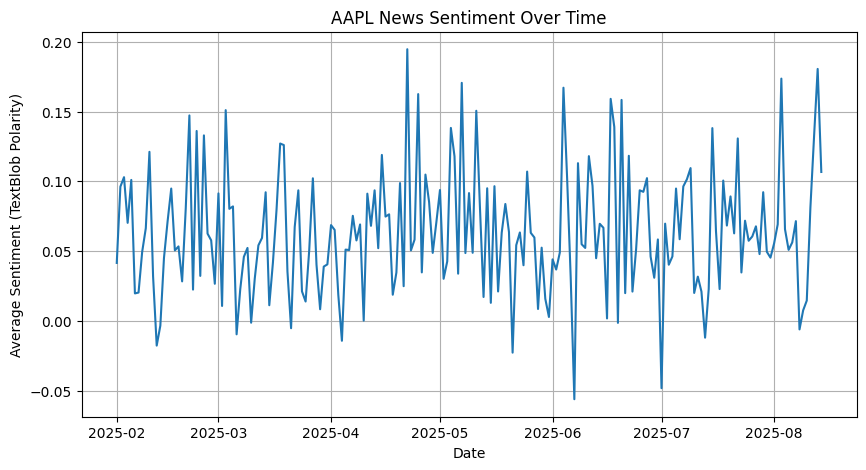

In [18]:
import matplotlib.pyplot as plt

# Group by date
daily_sentiment = aapl_news.groupby('date')['computed_sentiment'].mean()

plt.figure(figsize=(10,5))
plt.plot(daily_sentiment.index, daily_sentiment.values)
plt.title("AAPL News Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Average Sentiment (TextBlob Polarity)")
plt.grid(True)
plt.show()


In [19]:
aapl_news.to_csv("AAPL_news_filtered.csv", index=False)
print("✅ Exported AAPL_news_filtered.csv successfully!")

✅ Exported AAPL_news_filtered.csv successfully!
